Extended VQE
=============

In [Tutorial 1](https://docs.quantinuum.com/inquanto/tutorials/InQ_tut_vqe_1.html), we considered a canonical VQE calculation at a single geometry with no resource optimization.  However, in general, this will only be the first step in an analysis of the quantum algorithm.  We may wish to expand on this analysis by considering more molecular geometries or systems -- for example, looking at the energetics of bond dissociation.  We also may wish to compare optimization methods in order to assess their effectiveness at reducing the overall cost with regards to quantum computational resources.

In this tutorial, we will look at how to achieve these goals using InQuanto.  We start by examining bond dissociation in molecular hydrogen using a canonical VQE approach.  Then, we will look at a slightly larger system -- the bending and stretching of water.  As this is a larger system, we will have to introduce optimizations to enable the simulations to run on a standard laptop.  Specifically, we introduce how to reduce the active space (and thus the number of qubits in the quantum computation) by freezing orbitals using the [inquanto-pyscf](https://docs.quantinuum.com/inquanto/extensions/inquanto-pyscf.html) driver.  Finally, we look at one optimization strategy in InQuanto - Ansatz parameter reduction by point group symmetry. 

In [ ]:
from pytket.extensions.qiskit import AerStateBackend
from inquanto.express import run_vqe
from inquanto.minimizers import MinimizerScipy
from inquanto.ansatzes import FermionSpaceAnsatzUCCSD
from inquanto.mappings import QubitMappingJordanWigner
from inquanto.extensions.pyscf import ChemistryDriverPySCFMolecularRHF
import datetime
import matplotlib.pyplot as plt
import numpy as np

H2 Bond Stretching
------------------

  After imports, we start by examining bond dissociation in molecular hydrogen in order to present a general workflow.

In [ ]:
def hydrogen_vqe_energy(bond_length):
    basis = 'STO-3G'
    geometry = [["H", [0, 0, 0]], ["H", [0, 0, bond_length]]]
    charge = 0
    
    driver = ChemistryDriverPySCFMolecularRHF(basis=basis, geometry=geometry, charge=charge)
    fermionic_hamiltonian, fock_space, fock_state = driver.get_system()
    jw = QubitMappingJordanWigner
    qubit_hamiltonian = jw.operator_map(fermionic_hamiltonian)
    ansatz = FermionSpaceAnsatzUCCSD(fock_space, fock_state, jw)
    backend = AerStateBackend()
    minimizer = MinimizerScipy(method="L-BFGS-B", disp=False)
    vqe = run_vqe(ansatz, qubit_hamiltonian, backend=backend, with_gradient=True, minimizer=minimizer)

    ground_state_energy = vqe.generate_report()["final_value"]
    hartree_fock_energy = driver.mf_energy
    return ground_state_energy, hartree_fock_energy

print(hydrogen_vqe_energy(0.741))

# TIMER BLOCK-0 BEGINS AT 2023-11-29 10:03:18.932717
# TIMER BLOCK-0 ENDS - DURATION (s):  0.2546752 [0:00:00.254675]
(-1.1372744055294364, -1.116706137236105)


The code here does all that is necessary to generate a ground state energy using canonical VQE for the hydrogen molecule, as in [Tutorial 1](https://docs.quantinuum.com/inquanto/tutorials/InQ_tut_vqe_1.html).  Here, we have wrapped it in a function to allow us to easily view the change with bond length:

In [ ]:
h2_bond_lengths = np.linspace(0.4,2.0,20)
h2_results = [hydrogen_vqe_energy(x) for x in h2_bond_lengths]
print(h2_results)

# TIMER BLOCK-1 BEGINS AT 2023-11-29 10:03:19.444925
# TIMER BLOCK-1 ENDS - DURATION (s):  0.2311640 [0:00:00.231164]
# TIMER BLOCK-2 BEGINS AT 2023-11-29 10:03:19.750268
# TIMER BLOCK-2 ENDS - DURATION (s):  0.3098021 [0:00:00.309802]
# TIMER BLOCK-3 BEGINS AT 2023-11-29 10:03:20.149157
# TIMER BLOCK-3 ENDS - DURATION (s):  0.2040837 [0:00:00.204084]
# TIMER BLOCK-4 BEGINS AT 2023-11-29 10:03:20.414429
# TIMER BLOCK-4 ENDS - DURATION (s):  0.2530793 [0:00:00.253079]
# TIMER BLOCK-5 BEGINS AT 2023-11-29 10:03:20.898705
# TIMER BLOCK-5 ENDS - DURATION (s):  0.2698489 [0:00:00.269849]
# TIMER BLOCK-6 BEGINS AT 2023-11-29 10:03:21.238844
# TIMER BLOCK-6 ENDS - DURATION (s):  0.2238931 [0:00:00.223893]
# TIMER BLOCK-7 BEGINS AT 2023-11-29 10:03:21.529253
# TIMER BLOCK-7 ENDS - DURATION (s):  0.2436052 [0:00:00.243605]
# TIMER BLOCK-8 BEGINS AT 2023-11-29 10:03:21.839684
# TIMER BLOCK-8 ENDS - DURATION (s):  0.1830366 [0:00:00.183037]
# TIMER BLOCK-9 BEGINS AT 2023-11-29 10:03:22.185276
# T

We have successfully generated a potential energy curve for the dissociation of the H2 molecule using VQE and, as a reference, Hartree-Fock.  We can now separate the VQE and HF results and plot them:

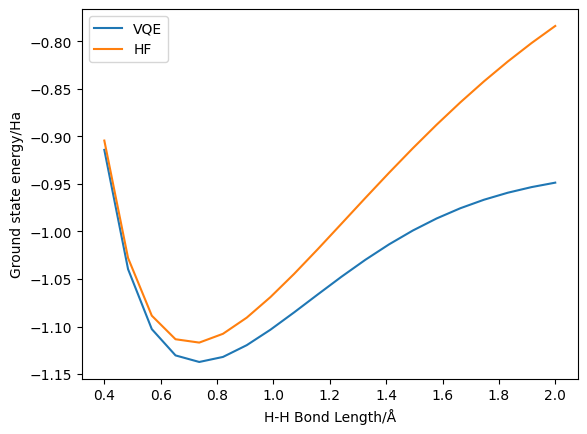

In [ ]:
h2_vqe_results,h2_hf_results = zip(*h2_results)
plt.plot(h2_bond_lengths,h2_vqe_results,label='VQE')
plt.plot(h2_bond_lengths,h2_hf_results,label='HF')
plt.xlabel('H-H Bond Length/Å')
plt.ylabel('Ground state energy/Ha')
plt.legend()

Here we can see the improvement obtained by using UCCSD VQE -- indeed, this system is sufficiently low in number of spin-orbitals that UCCSD is exact (i.e. FCI-level).  On the other hand, we can also observe the increasing inaccuracy of (restricted) Hartree-Fock at higher bond lengths.

H2O Bending - active space reduction
-------------------------------------

H2O in an STO-3G basis is a 14 spin-orbital (and thus 14 qubit for conventional qubit mappings) system.  This is within the capacity of a classical computer to simulate, but such a simulation may perhaps require more resources than is practical for this tutorial.  We can reduce the active spin-orbital space by freezing orbitals.  While our purpose here is to demonstrate, in a real experiment it may be necessary to freeze orbitals in order to reduce the (exponentially growing) resources to a level that is actually implementable.  In InQuanto, orbital freezing is performed by passing the `frozen` parameter to the driver:


In [ ]:
def water_bending_vqe_energy(bond_angle):
    
    x_h2 = np.sin(bond_angle / 360 * np.pi)
    x_h1 = -x_h2
    y_h1 = np.cos(bond_angle / 360 * np.pi)
    y_h2 = y_h1
    
    geometry = [['H', [x_h1, y_h1, 0.]], ['O', [0., 0., 0.]], ['H', [x_h2, y_h2, 0.]]]
    basis = 'STO-3G'
    charge = 0
    frozen = [0]
    
    driver = ChemistryDriverPySCFMolecularRHF(basis=basis, geometry=geometry, charge=charge, frozen=frozen)
    fermionic_hamiltonian, fock_space, fock_state = driver.get_system()
    jw = QubitMappingJordanWigner
    qubit_hamiltonian = jw.operator_map(fermionic_hamiltonian)
    ansatz = FermionSpaceAnsatzUCCSD(fock_space, fock_state, jw)
    backend = AerStateBackend()
    minimizer = MinimizerScipy(method="L-BFGS-B", disp=False)
    vqe = run_vqe(ansatz, qubit_hamiltonian, backend=backend, with_gradient=True, minimizer=minimizer)

    ground_state_energy = vqe.generate_report()["final_value"]
    hartree_fock_energy = driver.mf_energy
    return ground_state_energy, hartree_fock_energy

print(water_bending_vqe_energy(104.5))

# TIMER BLOCK-21 BEGINS AT 2023-11-29 10:03:30.842856
# TIMER BLOCK-21 ENDS - DURATION (s): 27.7681518 [0:00:27.768152]
(-75.01966834467395, -74.96466253913081)


This block may take up to a minute to run, as the system is a bit bigger than molecular hydrogen.  Here, we have asked the driver to freeze the lowest energy spatial orbital (i.e. the core electrons).  Note that frozen orbitals are specified as a list of indices of spatial orbitals, not spin-orbitals - so every orbital frozen in this way will save two qubits.  Note that for consistency, we have here specified the geometry in Cartesian co-ordinates by explicitly calculating the position of each atom.  It is also possible in InQuanto to specify geometries in z-matrix format.

As before, we have successfully calculated the VQE and HF energy at (roughly) the equilibrium geometry.  We can again calculate the effect of changing the bond angle and plot the results (this may take a few minutes to run - reducing the amount of data points generated will speed it up if needed):


In [ ]:
h2o_bond_angles = np.linspace(45.,180.,10)
h2o_bending_results = [water_bending_vqe_energy(x) for x in h2o_bond_angles]

# TIMER BLOCK-22 BEGINS AT 2023-11-29 10:04:00.885648
# TIMER BLOCK-22 ENDS - DURATION (s): 29.3601284 [0:00:29.360128]
# TIMER BLOCK-23 BEGINS AT 2023-11-29 10:04:32.660531
# TIMER BLOCK-23 ENDS - DURATION (s): 27.9207343 [0:00:27.920734]
# TIMER BLOCK-24 BEGINS AT 2023-11-29 10:05:02.711111
# TIMER BLOCK-24 ENDS - DURATION (s): 26.3334000 [0:00:26.333400]
# TIMER BLOCK-25 BEGINS AT 2023-11-29 10:05:31.376028
# TIMER BLOCK-25 ENDS - DURATION (s): 24.9143963 [0:00:24.914396]
# TIMER BLOCK-26 BEGINS AT 2023-11-29 10:05:58.777418
# TIMER BLOCK-26 ENDS - DURATION (s): 27.3104123 [0:00:27.310412]
# TIMER BLOCK-27 BEGINS AT 2023-11-29 10:06:28.389795
# TIMER BLOCK-27 ENDS - DURATION (s): 27.1425993 [0:00:27.142599]
# TIMER BLOCK-28 BEGINS AT 2023-11-29 10:06:58.433549
# TIMER BLOCK-28 ENDS - DURATION (s): 28.5798548 [0:00:28.579855]
# TIMER BLOCK-29 BEGINS AT 2023-11-29 10:07:29.744182
# TIMER BLOCK-29 ENDS - DURATION (s): 31.6896270 [0:00:31.689627]
# TIMER BLOCK-30 BEGINS AT 2023-11-29 10

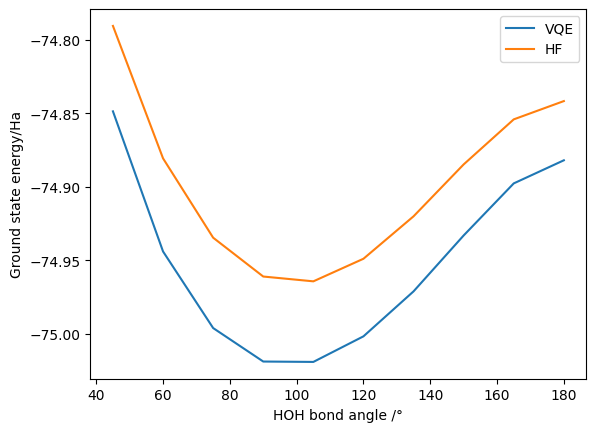

In [ ]:
h2o_angle_vqe_results,h2o_angle_hf_results = zip(*h2o_bending_results)
plt.plot(h2o_bond_angles,h2o_angle_vqe_results,label='VQE')
plt.plot(h2o_bond_angles,h2o_angle_hf_results,label='HF')
plt.xlabel('HOH bond angle /°')
plt.ylabel('Ground state energy/Ha')
plt.legend()

H2O Stretching - symmetry-allowed excitations
---------------------------------------------

In larger systems, we may be interested in benchmarking the cost of VQE with various optimization schemes.  Choosing optimization schemes is a question of balancing the need for accuracy and resource constraints.  Several resource constraints occur when performing quantum algorithms -- for instance, the number of qubits and the circuit length.  Similar to space and time in classical computing, certain optimization schemes may reduce cost in one metric while having a detrimental effect on others.  Such  tradeoff in resources applies to VQE itself; VQE as an algorithm is designed to replace the (extremely) long quantum circuits of the phase estimation algorithm with significantly more but much shorter circuits.

Many such optimization schemes are available in InQuanto and examples of their use can be found in the examples directory.  In this tutorial, we will look at the use of point group symmetry to exclude unphysical symmetry-violating excitations.  This is a technique commonly used in quantum chemistry codes on classical computers, and can substantially reduce the number of Ansatz parameters.  In turn, the quantum circuit length can be reduced, as is the difficulty of classical optimization (and consequentially the number of individual VQE shots required, and thus the overall runtime).  As this technique is simply removing excitations that are unphysical, it is essentially "free" with regards to other computational resources.

First, we modify our VQE routine to incorporate point group symmetry -- this time, in the context of symmetric bond stretching:

In [ ]:
def water_stretching_vqe_energy(bond_length):
    
    x_h2 = bond_length * np.sin(104.45 / 360 * np.pi)
    x_h1 = -x_h2
    y_h1 = bond_length * np.cos(104.45 / 360 * np.pi)
    y_h2 = y_h1
    
    geometry = [['H', [x_h1, y_h1, 0.]], ['O', [0., 0., 0.]], ['H', [x_h2, y_h2, 0.]]]
    basis = 'STO-3G'
    charge = 0
    frozen = [0]
    
    driver = ChemistryDriverPySCFMolecularRHF(basis=basis, geometry=geometry, charge=charge, frozen=frozen,point_group_symmetry=True)
    fermionic_hamiltonian, fock_space, fock_state = driver.get_system()
    jw = QubitMappingJordanWigner
    qubit_hamiltonian = jw.operator_map(fermionic_hamiltonian)
    ansatz = FermionSpaceAnsatzUCCSD(fock_space, fock_state, jw)
    backend = AerStateBackend()
    minimizer = MinimizerScipy(method="L-BFGS-B", disp=False)
    vqe = run_vqe(ansatz, qubit_hamiltonian, backend=backend, with_gradient=True, minimizer=minimizer)

    ground_state_energy = vqe.generate_report()["final_value"]
    hartree_fock_energy = driver.mf_energy
    return ground_state_energy, hartree_fock_energy
print(water_stretching_vqe_energy(1.))

# TIMER BLOCK-32 BEGINS AT 2023-11-29 10:09:03.058718
# TIMER BLOCK-32 ENDS - DURATION (s): 13.7481062 [0:00:13.748106]
(-75.01969733754343, -74.96468314023907)


Here, incorporating point group symmetry is as simple as passing `point_group_symmetry=True` to the driver.  Note that the ability to use point group symmetry is reliant on the capacity of the underlying classical quantum chemistry package (in this case, [PySCF](https://pyscf.org/)).  We then generate a plot of the change in the ground state energy as the bonds stretch:

In [ ]:
h2o_bond_lengths = np.linspace(0.6,2.,10)
h2o_stretching_results = [water_stretching_vqe_energy(x) for x in h2o_bond_lengths]

# TIMER BLOCK-33 BEGINS AT 2023-11-29 10:09:18.425163
# TIMER BLOCK-33 ENDS - DURATION (s): 13.3292246 [0:00:13.329225]
# TIMER BLOCK-34 BEGINS AT 2023-11-29 10:09:34.646286
# TIMER BLOCK-34 ENDS - DURATION (s): 13.9985131 [0:00:13.998513]
# TIMER BLOCK-35 BEGINS AT 2023-11-29 10:09:52.028530
# TIMER BLOCK-35 ENDS - DURATION (s): 13.5315848 [0:00:13.531585]
# TIMER BLOCK-36 BEGINS AT 2023-11-29 10:10:08.392973
# TIMER BLOCK-36 ENDS - DURATION (s): 12.2572551 [0:00:12.257255]
# TIMER BLOCK-37 BEGINS AT 2023-11-29 10:10:23.751241
# TIMER BLOCK-37 ENDS - DURATION (s): 14.3392197 [0:00:14.339220]
# TIMER BLOCK-38 BEGINS AT 2023-11-29 10:10:40.594766
# TIMER BLOCK-38 ENDS - DURATION (s): 13.9344880 [0:00:13.934488]
# TIMER BLOCK-39 BEGINS AT 2023-11-29 10:10:57.463713
# TIMER BLOCK-39 ENDS - DURATION (s): 12.4128931 [0:00:12.412893]
# TIMER BLOCK-40 BEGINS AT 2023-11-29 10:11:13.271035
# TIMER BLOCK-40 ENDS - DURATION (s): 16.7570208 [0:00:16.757021]
# TIMER BLOCK-41 BEGINS AT 2023-11-29 10

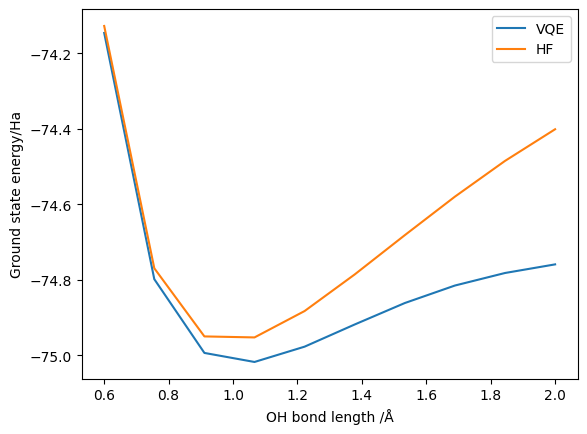

In [ ]:
h2o_lengths_vqe_results,h2o_lengths_hf_results = zip(*h2o_stretching_results)
plt.plot(h2o_bond_lengths,h2o_lengths_vqe_results,label='VQE')
plt.plot(h2o_bond_lengths,h2o_lengths_hf_results,label='HF')
plt.xlabel('OH bond length /Å')
plt.ylabel('Ground state energy/Ha')
plt.legend()

We have successfully demonstrated that the point group symmetry reductions yield the correct ground state energy. However, we have not yet looked at the resource reductions obtained.  We can adapt our VQE wrapper functions to return this, but for simplicity here we just look at one configuration:

In [ ]:
x_h2 = np.sin(104.45 / 360 * np.pi)
x_h1 = -x_h2
y_h1 = np.cos(104.45 / 360 * np.pi)
y_h2 = y_h1

geometry = [['H', [x_h1, y_h1, 0.]], ['O', [0., 0., 0.]], ['H', [x_h2, y_h2, 0.]]]
basis = 'STO-3G'
charge = 0
frozen = [0]
    
driver_with_symmetry = ChemistryDriverPySCFMolecularRHF(basis=basis, geometry=geometry, charge=charge, frozen=frozen,point_group_symmetry=True)
driver_without_symmetry = ChemistryDriverPySCFMolecularRHF(basis=basis, geometry=geometry, charge=charge, frozen=frozen,point_group_symmetry=False)
fermionic_hamiltonian_with_symmetry, fock_space_with_symmetry, fock_state_with_symmetry = driver_with_symmetry.get_system()
fermionic_hamiltonian_without_symmetry, fock_space_without_symmetry, fock_state_without_symmetry = driver_without_symmetry.get_system()
jw = QubitMappingJordanWigner()

ansatz_with_symmetry = FermionSpaceAnsatzUCCSD(fock_space_with_symmetry, fock_state_with_symmetry, jw)
ansatz_without_symmetry = FermionSpaceAnsatzUCCSD(fock_space_without_symmetry, fock_state_without_symmetry, jw)

For simplicity, we restrict ourselves to looking at the impact on the resources required for generating the Ansatz state.  Note that many quantum resources can be estimated without actually running VQE in this manner; this dramatically decreases the resources necessary to perform an experiment.

If we generate a report for each Ansatz:


In [ ]:
print('### ANSATZ RESOURCES WITH SYMMETRY REDUCTION ###')
print(ansatz_with_symmetry.generate_report())
print('\n### ANSATZ RESOURCES WITHOUT SYMMETRY REDUCTION ###')
print(ansatz_without_symmetry.generate_report())

### ANSATZ RESOURCES WITH SYMMETRY REDUCTION ###
{'ansatz_circuit_depth': 841, 'ansatz_circuit_gates': 2260, 'n_parameters': 30, 'n_qubits': 12}

### ANSATZ RESOURCES WITHOUT SYMMETRY REDUCTION ###
{'ansatz_circuit_depth': 2798, 'ansatz_circuit_gates': 7032, 'n_parameters': 92, 'n_qubits': 12}
